# Importing Brevitas networks into FINN with the QONNX interchange format

**Note: Previously it was possible to directly export the FINN-ONNX interchange format from Brevitas to pass to the FINN compiler. This support is deprecated and FINN uses the export to the QONNX format as a front end, internally FINN uses still the FINN-ONNX format.**

In this notebook we'll go through an example of how to import a Brevitas-trained QNN into FINN. The steps will be as follows:

1. Load up the trained PyTorch model
2. Call Brevitas QONNX export and visualize with Netron
3. Import into FINN and converting QONNX to FINN-ONNX

We'll use the following utility functions to print the source code for function calls (`showSrc()`) and to visualize a network using netron (`showInNetron()`) in the Jupyter notebook:

In [1]:
import onnx
from finn.util.visualization import showSrc, showInNetron

## 1. Load up the trained PyTorch model

The FINN Docker image comes with several [example Brevitas networks](https://github.com/Xilinx/brevitas/tree/master/src/brevitas_examples/bnn_pynq), and we'll use the LFC-w1a1 model as the example network here. This is a binarized fully connected network trained on the MNIST dataset. Let's start by looking at what the PyTorch network definition looks like:

In [2]:
from brevitas_examples import bnn_pynq
showSrc(bnn_pynq.models.FC)

# Copyright (C) 2023, Advanced Micro Devices, Inc. All rights reserved.
# SPDX-License-Identifier: BSD-3-Clause

import ast
from functools import reduce
from operator import mul

import torch
from torch.nn import BatchNorm1d
from torch.nn import Dropout
from torch.nn import Module
from torch.nn import ModuleList

from brevitas.nn import QuantIdentity
from brevitas.nn import QuantLinear

from .common import CommonActQuant
from .common import CommonWeightQuant
from .tensor_norm import TensorNorm

DROPOUT = 0.2


class FC(Module):

    def __init__(
        self,
        num_classes,
        weight_bit_width,
        act_bit_width,
        in_bit_width,
        in_channels,
        out_features,
        in_features=(28, 28)):
        super(FC, self).__init__()

        self.features = ModuleList()
        self.features.append(QuantIdentity(act_quant=CommonActQuant, bit_width=in_bit_width))
        self.features.append(Dropout(p=DROPOUT))
        in_features = reduce(mul, in_features)
    

We can see that the network topology is constructed using a few helper functions that generate the quantized linear layers and quantized activations. The bitwidth of the layers is actually parametrized in the constructor, so let's instantiate a 1-bit weights and activations version of this network. We also have pretrained weights for this network, which we will load into the model.

In [3]:
from finn.util.test import get_test_model
lfc = get_test_model(netname = "LFC", wbits = 1, abits = 1, pretrained = True)
lfc

Downloading: "https://github.com/Xilinx/brevitas/releases/download/bnn_pynq-r1/lfc_1w1a-318d8bd9.pth" to /tmp/home_dir/.cache/torch/hub/checkpoints/lfc_1w1a-318d8bd9.pth


  0%|          | 0.00/11.2M [00:00<?, ?B/s]

FC(
  (features): ModuleList(
    (0): QuantIdentity(
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (act_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
        (fused_activation_quant_proxy): FusedActivationQuantProxy(
          (activation_impl): Identity()
          (tensor_quant): ClampedBinaryQuant(
            (scaling_impl): ConstScaling(
              (restrict_clamp_scaling): _RestrictClampValue(
                (clamp_min_ste): Identity()
                (restrict_value_impl): FloatRestrictValue()
              )
              (value): StatelessBuffer()
            )
            (bit_width): BitWidthConst(
              (bit_width): StatelessBuffer()
            )
            (zero_point): StatelessBuffer()
            (delay_wrapper): DelayWrapper(
              (delay_impl): _NoDelay()
            )
            (tensor_clamp_impl): TensorClamp()
          )
        )
      )
   

We have now instantiated our trained PyTorch network. Let's try to run an example MNIST image through the network using PyTorch.

/tmp/ipykernel_138/1417966531.py:9: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  input_tensor_pyt = torch.from_numpy(input_tensor_npy).float()


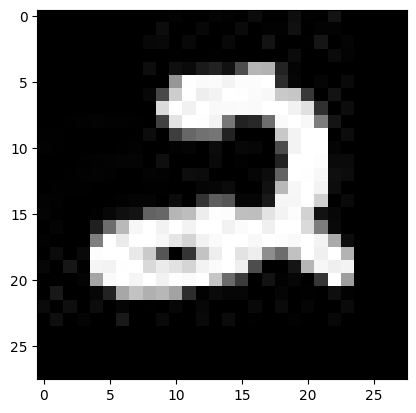

In [4]:
import torch
import matplotlib.pyplot as plt
from pkgutil import get_data
import onnx
import onnx.numpy_helper as nph
raw_i = get_data("qonnx.data", "onnx/mnist-conv/test_data_set_0/input_0.pb")
input_tensor = onnx.load_tensor_from_string(raw_i)
input_tensor_npy = nph.to_array(input_tensor)
input_tensor_pyt = torch.from_numpy(input_tensor_npy).float()
imgplot = plt.imshow(input_tensor_npy.reshape(28,28), cmap='gray')

In [5]:
from torch.nn.functional import softmax
# do forward pass in PyTorch/Brevitas
produced = lfc.forward(input_tensor_pyt).detach()
probabilities = softmax(produced, dim=-1).flatten()
probabilities

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1255: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1758.)
  return super(Tensor, self).rename(names)


tensor([0.1020, 0.0113, 0.4806, 0.0571, 0.0482, 0.0079, 0.0450, 0.0076, 0.1851,
        0.0552])

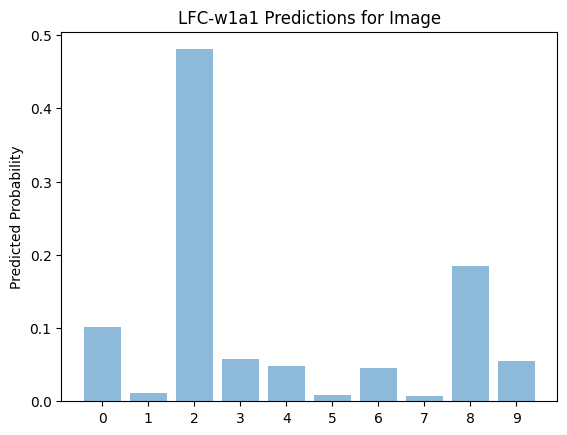

In [6]:
import numpy as np
objects = [str(x) for x in range(10)]
y_pos = np.arange(len(objects))
plt.bar(y_pos, probabilities, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Predicted Probability')
plt.title('LFC-w1a1 Predictions for Image')
plt.show()

## 2. Call Brevitas QONNX export and visualize with Netron

Brevitas comes with built-in QONNX export functionality. This is similar to the regular ONNX export capabilities of PyTorch, with a few differences:

1. Weight and activation quantization is represented as a 'fake-quantization' with Quant and BipolarQuant nodes.
2. Truncation operations as required by average pooling are represented with a Trunc node.

One can read more about how QONNX works and why it was developed here: https://xilinx.github.io/finn//2021/11/03/qonnx-and-finn.html

Additionally QONNX comes with a set of tools for working with the format. These are maintained together with the Fast Machinelearning collaboration as an open-source projet here: https://github.com/fastmachinelearning/qonnx

It's actually quite straightforward to export QONNX from our Brevitas model as follows:

In [8]:
from brevitas.export import export_qonnx
export_onnx_path = "./LFCW1A1_qonnx.onnx"
input_shape = (1, 1, 28, 28)
export_qonnx(lfc, torch.randn(input_shape), export_onnx_path);

Let's examine what the exported ONNX model looks like. For this, we will use the Netron visualizer:

In [9]:
showInNetron(export_onnx_path)

Serving './LFCW1A1_qonnx.onnx' at http://0.0.0.0:8081


When running this notebook in the FINN Docker container, you should be able to see an interactive visualization of the imported network above, and click on individual nodes to inspect their parameters. If you look at any of the MatMul nodes, you should be able to see that the weights are all {-1, +1} values.

## 3. Import into FINN and converting QONNX to FINN-ONNX

We will first run a cleanup transformation on the exported QONNX model.

In [10]:
from qonnx.util.cleanup import cleanup

export_onnx_path_cleaned = "./LFCW1A1-qonnx-clean.onnx"
cleanup(export_onnx_path, out_file=export_onnx_path_cleaned)

In [11]:
showInNetron(export_onnx_path_cleaned)

Stopping http://0.0.0.0:8081
Serving './LFCW1A1-qonnx-clean.onnx' at http://0.0.0.0:8081


We will now import this QONNX model into FINN using the ModelWrapper. Here we can immediatley execute the model to verify correctness.

In [12]:
from qonnx.core.modelwrapper import ModelWrapper
import qonnx.core.onnx_exec as oxe
model = ModelWrapper(export_onnx_path_cleaned)
input_dict = {"global_in": nph.to_array(input_tensor)}
output_dict = oxe.execute_onnx(model, input_dict)
produced_qonnx = output_dict[list(output_dict.keys())[0]]

produced_qonnx

array([[-1.3736125, -3.5715756,  0.1768887, -1.9529207, -2.1233053,
        -3.9293835, -2.1914592, -3.9634604, -0.7772659, -1.9869976]],
      dtype=float32)

In [13]:
np.isclose(produced, produced_qonnx).all()

True

Using the `QONNXtoFINN` transformation we can convert the model to the FINN internal FINN-ONNX representation. Notably all Quant and BipolarQuant nodes will have disappeared and are converted into MultiThreshold nodes.

In [14]:
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN
model = ModelWrapper(export_onnx_path_cleaned)

model = model.transform(ConvertQONNXtoFINN())

export_onnx_path_converted = "./LFCW1A1-qonnx-converted.onnx"
model.save(export_onnx_path_converted)

In [15]:
showInNetron(export_onnx_path_converted)

Stopping http://0.0.0.0:8081
Serving './LFCW1A1-qonnx-converted.onnx' at http://0.0.0.0:8081


And once again we can execute the model with the FINN/QONNX execution engine.

In [16]:
model = ModelWrapper(export_onnx_path_converted)
input_dict = {"global_in": nph.to_array(input_tensor)}
output_dict = oxe.execute_onnx(model, input_dict)
produced_finn = output_dict[list(output_dict.keys())[0]]

produced_finn

array([[-1.3736125, -3.5715756,  0.1768887, -1.9529207, -2.1233053,
        -3.9293835, -2.1914592, -3.9634604, -0.7772659, -1.9869976]],
      dtype=float32)

In [17]:
np.isclose(produced_qonnx, produced_finn).all()

True

We have succesfully verified that the transformed and cleaned-up FINN graph still produces the same output, and can now use this model for further processing in FINN.